In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss

In [2]:
n_features = 2
# Generate synthetic data with the specified parameters
X, y = datasets.make_classification(n_samples=30, n_features=2, n_classes=2, n_clusters_per_class=2, n_redundant=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate hinge loss on the test data
test_loss = hinge_loss(y_test, y_pred)

print(f"Test Loss: {test_loss:.4f}")

# Get the indices of support vectors
support_vector_indices = svm_classifier.support_

print("Indices of Support Vectors:")
print(support_vector_indices)

Accuracy: 88.89%
Test Loss: 0.6667
Indices of Support Vectors:
[ 1  7  8 12 20  4 11 15 16 18]


In [3]:
# Initialize variables to store the nearest test point index and distance
nearest_point_index = None
nearest_distance = float("inf")

# Iterate through all test points to find the nearest point to the decision boundary
for i, test_point in enumerate(X_test):
    # Calculate the signed distance to the decision boundary for the current test point
    distance_to_boundary = svm_classifier.decision_function([test_point])
    
    # Get the absolute distance
    abs_distance = np.abs(distance_to_boundary)
    
    # Update the nearest point if the current test point is closer to the decision boundary
    if abs_distance < nearest_distance:
        nearest_distance = abs_distance
        nearest_point_index = i

# Get the index of the nearest test point
nearest_test_point_index = nearest_point_index

print(f"Index of Nearest Test Point to Decision Boundary: {nearest_test_point_index}")

Index of Nearest Test Point to Decision Boundary: 5


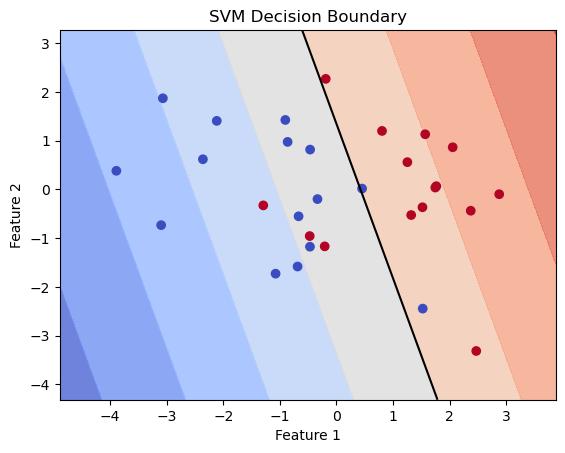

In [4]:
if n_features == 2:
	# Plot the decision boundary
	xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
						np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
	Z = svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
	Z = Z.reshape(xx.shape)

	plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
	plt.contour(xx, yy, Z, colors='black', linestyles='-', levels=[0])
	plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('SVM Decision Boundary')
	plt.show()
else: 
	from sklearn.decomposition import PCA

	# Reduce dimensionality using PCA to 2 components
	pca = PCA(n_components=2)
	X_pca = pca.fit_transform(X)

	# Create a mesh grid for the reduced feature space
	x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
	y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
	Z = svm_classifier.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
	Z = Z.reshape(xx.shape)

	# Plot the decision boundary in the reduced 2D space
	plt.contour(xx, yy, Z, colors='black', linestyles='--', levels=[0])
	plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm, marker='o')
	plt.xlabel('Principal Component 1')
	plt.ylabel('Principal Component 2')
	plt.title('SVM Decision Boundary (Reduced to 2D)')
	plt.show()

In [5]:
from itertools import combinations

# Choose a fixed test point
fixed_test_point_index = nearest_test_point_index
fixed_test_point = X_test[fixed_test_point_index]
true_label = y_test[fixed_test_point_index]
original_loss = hinge_loss([true_label], [svm_classifier.predict([fixed_test_point])])

max_size = 3
# Loop over different subset sizes from 1 to max_size
for subset_size in range(1, max_size):
	# Generate all combinations of subsets of the current size
	subset_combinations = combinations(range(X_train.shape[0]), subset_size)
	
	# Initialize variables to keep track of the best subset and loss difference
	
	best_subset = None
	max_loss_difference = 0.0

	for subset_to_remove in subset_combinations:
		# Create a new training set
		reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
		reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)
		
		# Train an SVM classifier on the reduced training set
		reduced_svm_classifier = SVC(kernel='linear', C=1.0)
		reduced_svm_classifier.fit(reduced_X_train, reduced_y_train)
		
		# Make predictions on the fixed test point
		reduced_y_pred = reduced_svm_classifier.predict([fixed_test_point])
		
		# Calculate hinge loss for the reduced classifier
		reduced_loss = hinge_loss([true_label], reduced_y_pred)
		
		# Calculate the loss difference
		loss_difference = original_loss - reduced_loss
		
		# Update if the current subset induces the maximum change in test loss
		if loss_difference > max_loss_difference:
			max_loss_difference = loss_difference
			best_subset = subset_to_remove

	# Print the best subset and the maximum loss difference
	print("--------------------------------------------------------")
	print(f"for removal size {subset_size}:")
	print(f"Best Subset of Features: {best_subset}")
	print(f"Maximum Loss Difference: {max_loss_difference:.4f}")

--------------------------------------------------------
for removal size 1:
Best Subset of Features: None
Maximum Loss Difference: 0.0000
--------------------------------------------------------
for removal size 2:
Best Subset of Features: None
Maximum Loss Difference: 0.0000


In [6]:
from itertools import combinations

def brute_force_removal_fixed_test_point(original_svm_classifier, X_train, y_train, fixed_test_point, true_label, original_loss, max_size):
	# Loop over different subset sizes from 1 to max_size
	for subset_size in range(1, max_size + 1):
		# Generate all combinations of subsets of the current size
		subset_combinations = combinations(range(X_train.shape[0]), subset_size)
		
		# Initialize variables to keep track of the best subset and loss difference
		best_subset = None
		best_reduced_Z = None
		max_loss_difference = -float("inf")

		for subset_to_remove in subset_combinations:
			# Create a new training set without the selected data points
			reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
			reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)
			
			# Train an SVM classifier on the reduced training set
			reduced_svm_classifier = SVC(kernel='linear', C=1.0)
			reduced_svm_classifier.fit(reduced_X_train, reduced_y_train)
			
			# Calculate the decision boundary for the reduced model
			xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
								np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))
			reduced_Z = reduced_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
			reduced_Z = reduced_Z.reshape(xx.shape)
			
			# Make predictions on the fixed test point using the reduced model
			reduced_y_pred = reduced_svm_classifier.predict([fixed_test_point])
			
			# Calculate hinge loss for the reduced model
			reduced_loss = hinge_loss([true_label], [reduced_y_pred])
			
			# Calculate the loss difference
			loss_difference = abs(original_loss - reduced_loss)
			
			if best_subset is None:
				best_subset = subset_to_remove

			# Update if the current subset induces the maximum change in test loss
			if loss_difference > max_loss_difference:
				max_loss_difference = loss_difference
				best_subset = subset_to_remove
				best_reduced_Z = reduced_Z
		
		# Print the best subset and the maximum loss difference
		print(f"for removal size {subset_size}:")
		print(f"Best Subset of Removal Dataset: {best_subset}")
		print(f"Maximum Loss Difference: {max_loss_difference:.4f}")
		
		
		# Plot the decision boundary of the original model and the reduced model, and mark the test point
		plt.figure()

		# Plot the decision boundary of the reduced model (solid line)
		plt.contourf(xx, yy, best_reduced_Z, cmap=plt.cm.coolwarm, alpha=0.8)
		plt.contour(xx, yy, best_reduced_Z, colors='black', linestyles='-', levels=[0])

		# Plot the decision boundary of the original model (dashed line)
		original_Z = original_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
		plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

		# Mark the dataset points with a marker ('o' symbol)
		plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

		# Mark the test point with a marker ('x' symbol)
		plt.scatter(fixed_test_point[0], fixed_test_point[1], c=true_label, marker='x', s=100, label="Test Point")
		
		# Mark the best subset of removed data points with a different marker ('^' symbol)
		best_subset_points = np.take(X_train, best_subset, axis=0).reshape(-1, 2)
		plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")
		
		plt.xlabel('Feature 1')
		plt.ylabel('Feature 2')
		plt.title(f'Decision Boundary with Removal Size {subset_size}')
		plt.legend()
		plt.show()

def brute_force_removal_total_loss(original_svm_classifier, X_train, y_train, X_test, y_test, original_loss, max_size):
	# Loop over different subset sizes from 1 to max_size
	for subset_size in range(1, max_size + 1):
		# Generate all combinations of subsets of the current size
		subset_combinations = combinations(range(X_train.shape[0]), subset_size)
		
		# Initialize variables to keep track of the best subset and loss difference
		best_subset = None
		best_reduced_Z = None
		max_loss_difference = -float("inf")

		for subset_to_remove in subset_combinations:
			# Create a new training set without the selected data points
			reduced_X_train = np.delete(X_train, subset_to_remove, axis=0)
			reduced_y_train = np.delete(y_train, subset_to_remove, axis=0)
			
			# Train an SVM classifier on the reduced training set
			reduced_svm_classifier = SVC(kernel='linear', C=1.0)
			reduced_svm_classifier.fit(reduced_X_train, reduced_y_train)
			
			# Calculate the decision boundary for the reduced model
			xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
								np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))
			reduced_Z = reduced_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
			reduced_Z = reduced_Z.reshape(xx.shape)
			
			# Make predictions on the fixed test point using the reduced model
			reduced_y_pred = reduced_svm_classifier.predict(X_test)
			
			# Calculate hinge loss for the reduced model
			reduced_loss = hinge_loss(y_test, reduced_y_pred)
			
			# Calculate the loss difference
			loss_difference = abs(original_loss - reduced_loss)
			
			if best_subset is None:
				best_subset = subset_to_remove

			# Update if the current subset induces the maximum change in test loss
			if loss_difference > max_loss_difference:
				max_loss_difference = loss_difference
				best_subset = subset_to_remove
				best_reduced_Z = reduced_Z
		
		# Print the best subset and the maximum loss difference
		print(f"for removal size {subset_size}:")
		print(f"Best Subset of Removal Dataset: {best_subset}")
		print(f"Maximum Loss Difference: {max_loss_difference:.4f}")
		
		# Plot the decision boundary of the original model and the reduced model, and mark the test point
		plt.figure()

		# Plot the decision boundary of the reduced model (solid line)
		plt.contourf(xx, yy, best_reduced_Z, cmap=plt.cm.coolwarm, alpha=0.8)
		plt.contour(xx, yy, best_reduced_Z, colors='black', linestyles='-', levels=[0])

		# Plot the decision boundary of the original model (dashed line)
		original_Z = original_svm_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
		plt.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

		# Mark the dataset points with a marker ('o' symbol)
		plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
		
		# Mark the best subset of removed data points with a different marker ('^' symbol)
		best_subset_points = np.take(X_train, best_subset, axis=0).reshape(-1, 2)
		plt.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='g', marker='^', s=100, label="Best Subset")
		
		plt.xlabel('Feature 1')
		plt.ylabel('Feature 2')
		plt.title(f'Decision Boundary with Removal Size {subset_size}')
		plt.legend()
		plt.show()

for removal size 1:
Best Subset of Removal Dataset: (0,)
Maximum Loss Difference: 0.0000


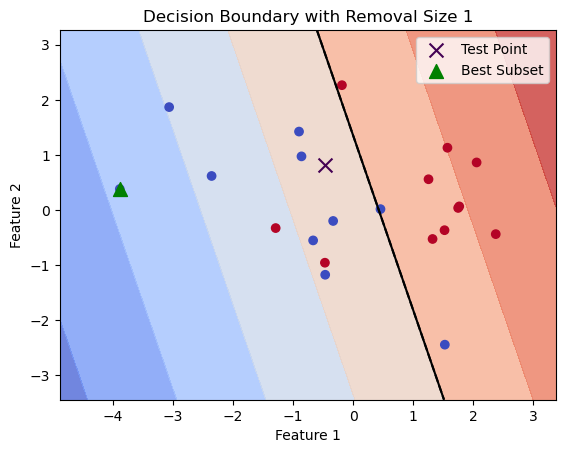

for removal size 2:
Best Subset of Removal Dataset: (1, 6)
Maximum Loss Difference: 1.0000


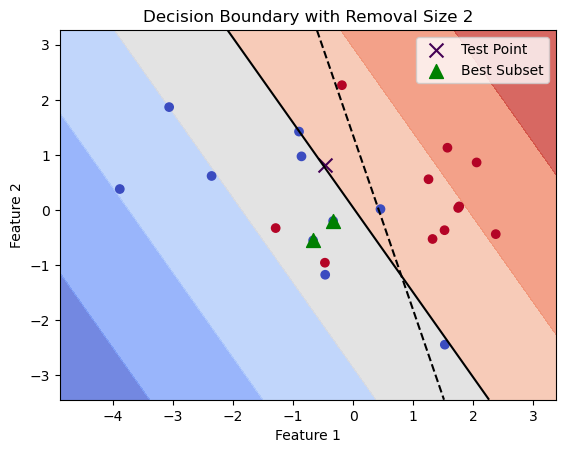

for removal size 3:
Best Subset of Removal Dataset: (0, 1, 6)
Maximum Loss Difference: 1.0000


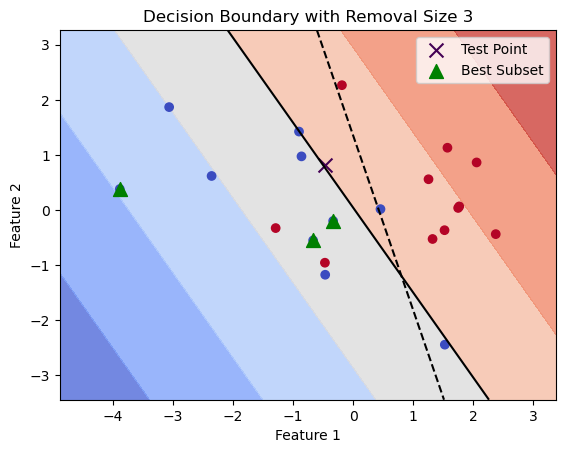

for removal size 4:
Best Subset of Removal Dataset: (0, 1, 2, 6)
Maximum Loss Difference: 1.0000


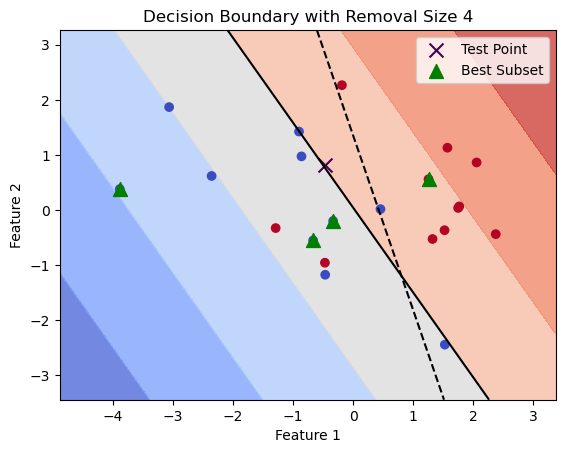

for removal size 5:
Best Subset of Removal Dataset: (0, 1, 2, 3, 6)
Maximum Loss Difference: 1.0000


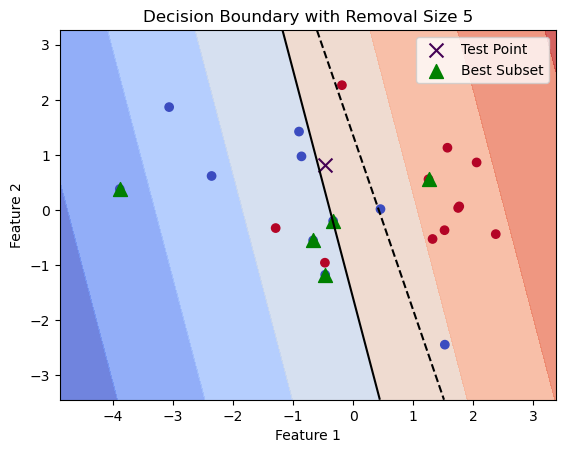

In [7]:
# Choose a fixed test point
fixed_test_point_index = nearest_test_point_index  # Replace with the index of your chosen test point
fixed_test_point = X_test[fixed_test_point_index]
true_label = y_test[fixed_test_point_index]

# Calculate the loss for the original model
original_loss = hinge_loss([true_label], [svm_classifier.predict([fixed_test_point])])

max_size = 5

brute_force_removal_fixed_test_point(svm_classifier, X_train, y_train, fixed_test_point, true_label, original_loss, max_size)

for removal size 1:
Best Subset of Removal Dataset: (4,)
Maximum Loss Difference: 0.1111


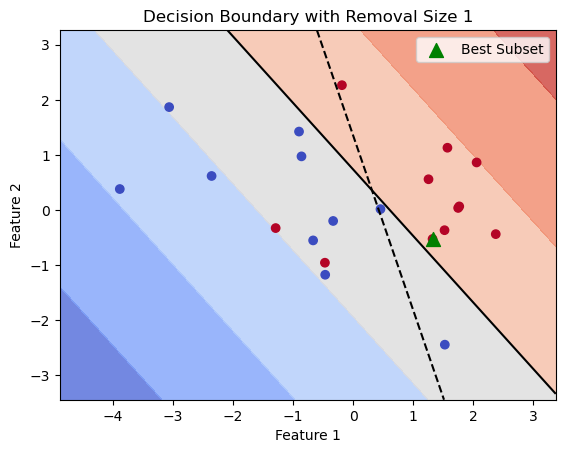

for removal size 2:
Best Subset of Removal Dataset: (1, 20)
Maximum Loss Difference: 0.2222


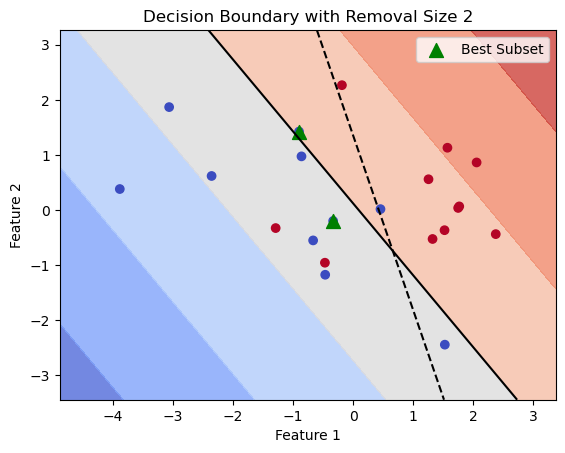

for removal size 3:
Best Subset of Removal Dataset: (0, 1, 20)
Maximum Loss Difference: 0.2222


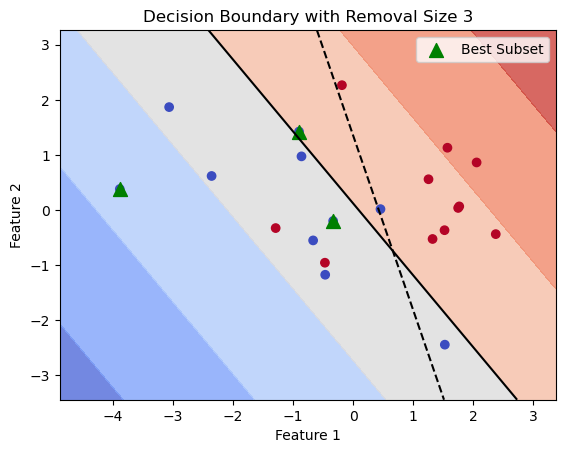

for removal size 4:
Best Subset of Removal Dataset: (7, 9, 14, 20)
Maximum Loss Difference: 0.3333


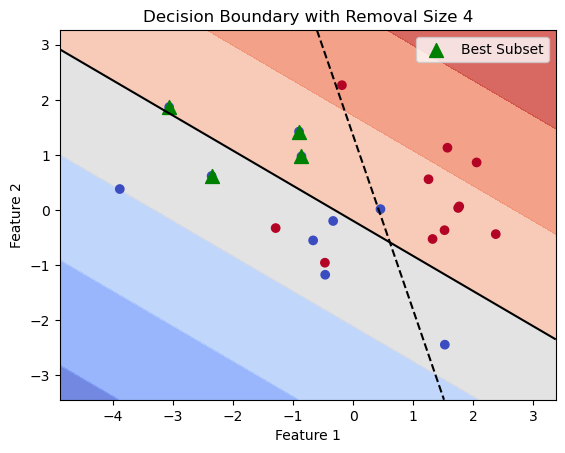

for removal size 5:
Best Subset of Removal Dataset: (0, 7, 9, 14, 20)
Maximum Loss Difference: 0.3333


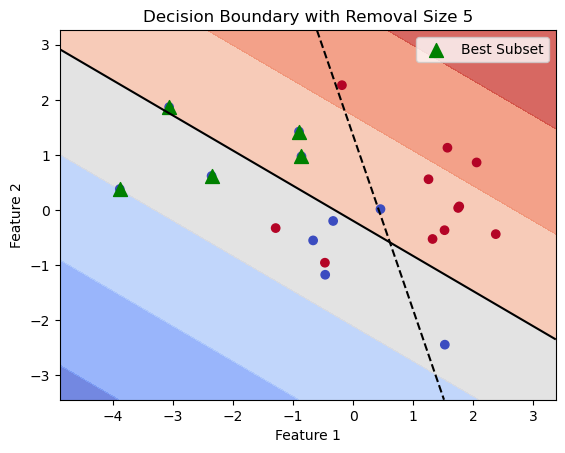

In [8]:
# Calculate the loss for the original model
original_loss = hinge_loss(y_test, y_pred)

brute_force_removal_total_loss(svm_classifier, X_train, y_train, X_test, y_test, original_loss, max_size)